# Data preprocessing, model training and model selection

In [ ]:
!pip install pystan
!pip install fbprophet

### Import of dependencies

In [196]:
# autosave every 60 seconds
%autosave 60

#display full output in Notebook, instead of only the last result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MaxNLocator
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#import standard libraries
import numpy as np
import pandas as pd
import os


#make this notebook's output stable across runs
np.random.seed(42)
    
#ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action='ignore', message='^internal gelsd')

#preprocessing libraries
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from datetime import datetime, timezone
import time

#model libraries
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from fbprophet import Prophet


#evaluation libraries
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.base import clone

#viz
import seaborn as sns
plt.style.use('fivethirtyeight')


#store model
import pickle

Autosaving every 60 seconds


### Import data

In [10]:
data_folder = '/00_data'
data_path = os.getcwd() + data_folder

In [197]:
#define variables
rapperswil_data = 'rapperswil.csv'

#function to import data
def load_data(data_path, data_type):
    csv_path = os.path.join(data_path, data_type)
    return pd.read_csv(csv_path, sep=';')

#load data
df = load_data(data_path, rapperswil_data)

**Data cleaning**

In [198]:
#rename columns
df = df.rename(columns={'Datum': 'date', 'BELEGUNGSQUOTE (%)': 'occupancy_rate'})

#convert date column into datetime format
df['date'] = pd.to_datetime(df['date'])

#remove time zone
df['date'] = df['date'].apply(lambda x: x.replace(tzinfo=None))

In [45]:
df.dtypes

date              datetime64[ns]
occupancy_rate           float64
dtype: object

In [199]:
df['date_only'] = df['date'].dt.date

**Data exploration**

In [127]:
#create function for feature creation

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    #df['id'] = df.index
    df['date_only'] = df['date'].dt.date
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    return df

    #X = df[['date_only','hour','dayofweek','quarter','month','year',
    #      'dayofyear','dayofmonth','weekofyear']]
    #if label:
    #    y = df[label], 2
    #   return X, y
    #return X

#X, y = create_features(df, label='occupancy_rate')

#features_and_target = pd.concat([X, y], axis=1)

In [96]:
#execute function
df = create_features(df, label=None)

**A. Occupancy rate per date**

<BarContainer object of 6346 artists>

Text(0.5, 1.0, 'Occupancy rate per date')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Occupancy rate')

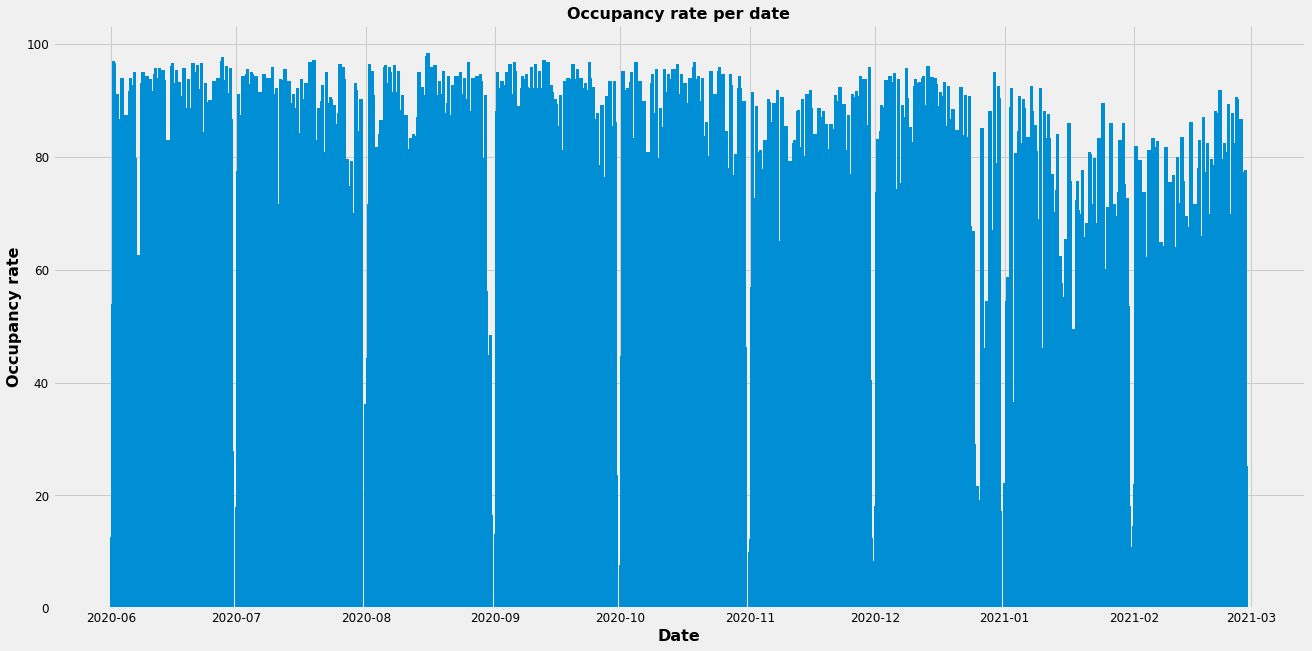

In [89]:
#show overall occupancy rate per date
y = df['occupancy_rate']
x = df['date']


fig = plt.figure(figsize=(20,10));
ax = fig.add_subplot(111);

plt.bar(x, y);
plt.title('Occupancy rate per date', fontsize = 16, weight = 'bold');
plt.xlabel('Date', fontsize = 16, weight = 'bold');
plt.ylabel('Occupancy rate', fontsize = 16, weight = 'bold');
plt.show()


**B. Occupancy rate per day hour across all days available**

<BarContainer object of 24 artists>

Text(0.5, 1.0, 'Occupancy rate per dayhour')

Text(0.5, 0, 'Hour of day')

Text(0, 0.5, 'Occupancy rate')

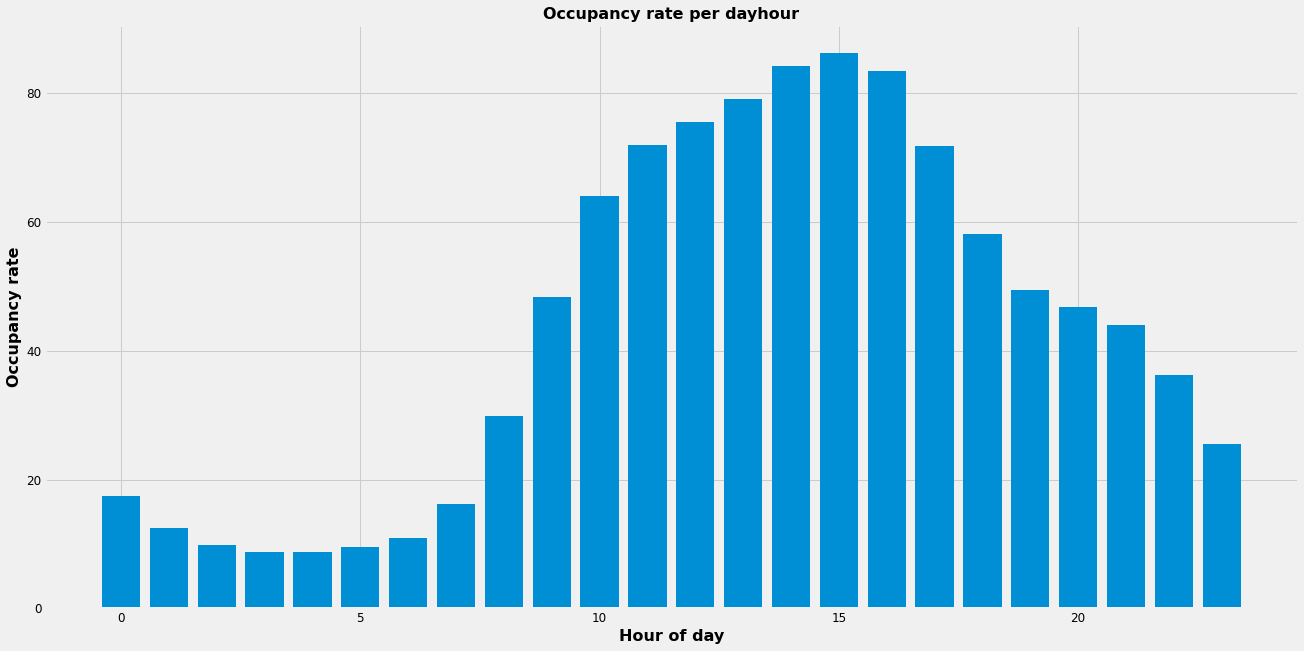

In [101]:
#show occupancy rate per hours of day
y = df.groupby('hour')['occupancy_rate'].mean()
x = df.groupby('hour')['occupancy_rate'].mean().index


fig = plt.figure(figsize=(20,10));
ax = fig.add_subplot(111);

plt.bar(x, y);
plt.title('Occupancy rate per dayhour', fontsize = 16, weight = 'bold');
plt.xlabel('Hour of day', fontsize = 16, weight = 'bold');
plt.ylabel('Occupancy rate', fontsize = 16, weight = 'bold');
plt.show()

**C. Occupancy rate per weekday across all days available**

<BarContainer object of 7 artists>

Text(0.5, 1.0, 'Occupancy rate per weekdayr')

Text(0.5, 0, 'Day of week')

Text(0, 0.5, 'Occupancy rate')

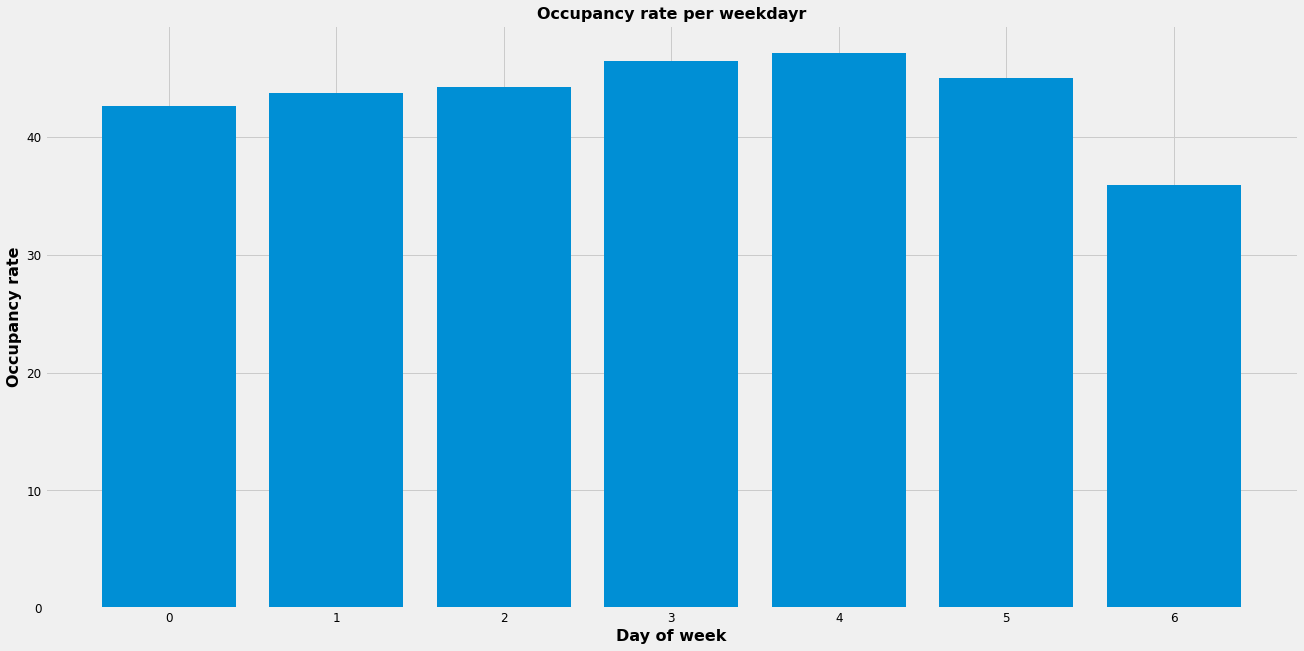

In [102]:
#show occupancy rate per weekday
y = df.groupby('dayofweek')['occupancy_rate'].mean()
x = df.groupby('dayofweek')['occupancy_rate'].mean().index


fig = plt.figure(figsize=(20,10));
ax = fig.add_subplot(111);

plt.bar(x, y);
plt.title('Occupancy rate per weekdayr', fontsize = 16, weight = 'bold');
plt.xlabel('Day of week', fontsize = 16, weight = 'bold');
plt.ylabel('Occupancy rate', fontsize = 16, weight = 'bold');
plt.show()

## Model Training

**Train / Test Split**

In [149]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    #df['date'] = df.index
    #df['date_only'] = df['date'].dt.date
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='occupancy_rate')

features_and_target = pd.concat([X, y], axis=1)
#X, y = create_features(df, label='occupancy_rate')

In [201]:
#split into train and test set
#pjme_train, pjme_test = train_test_split(df, test_size=0.2, random_state=42)

split_date = pd.datetime(2021,2,15)
pjme_train = df.loc[df['date'] <= split_date]
pjme_test = df.loc[df['date'] > split_date]

<ipython-input-201-eabaed761a68>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  split_date = pd.datetime(2021,2,15)


Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model

In [202]:
pjme_train.reset_index().rename(columns={'date':'ds','occupancy_rate':'y'}).head()

,index,ds,y,date_only
0,0,2020-08-01 01:00:00,36.163522,2020-08-01
1,1,2020-08-01 04:00:00,9.748428,2020-08-01
2,2,2020-08-01 06:00:00,9.119497,2020-08-01
3,3,2020-08-01 10:00:00,16.981132,2020-08-01
4,4,2020-08-01 19:00:00,71.698113,2020-08-01


In [203]:
# Setup and train model and fit
model = Prophet()
model.fit(pjme_train.reset_index().rename(columns={'date':'ds','occupancy_rate':'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [204]:
# Predict on training set with model
pjme_test_fcst = model.predict(df=pjme_test.reset_index().rename(columns={'date':'ds'}))

In [205]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-02-15 01:00:00,35.228162,-22.210476,16.610081,35.228162,35.228162,-37.983221,-37.983221,-37.983221,-33.211169,-33.211169,-33.211169,-4.772052,-4.772052,-4.772052,0.0,0.0,0.0,-2.755059
1,2021-02-15 02:00:00,35.227065,-22.806290,13.894322,35.227065,35.227065,-39.253584,-39.253584,-39.253584,-34.810429,-34.810429,-34.810429,-4.443156,-4.443156,-4.443156,0.0,0.0,0.0,-4.026519
2,2021-02-15 03:00:00,35.225967,-20.574113,15.589309,35.225967,35.225967,-37.947707,-37.947707,-37.947707,-33.847820,-33.847820,-33.847820,-4.099887,-4.099887,-4.099887,0.0,0.0,0.0,-2.721740
3,2021-02-15 04:00:00,35.224870,-20.001024,17.045337,35.224870,35.224870,-37.717722,-37.717722,-37.717722,-33.972110,-33.972110,-33.972110,-3.745612,-3.745612,-3.745612,0.0,0.0,0.0,-2.492852
4,2021-02-15 05:00:00,35.223773,-21.175626,15.194957,35.223773,35.223773,-38.979300,-38.979300,-38.979300,-35.595544,-35.595544,-35.595544,-3.383756,-3.383756,-3.383756,0.0,0.0,0.0,-3.755527


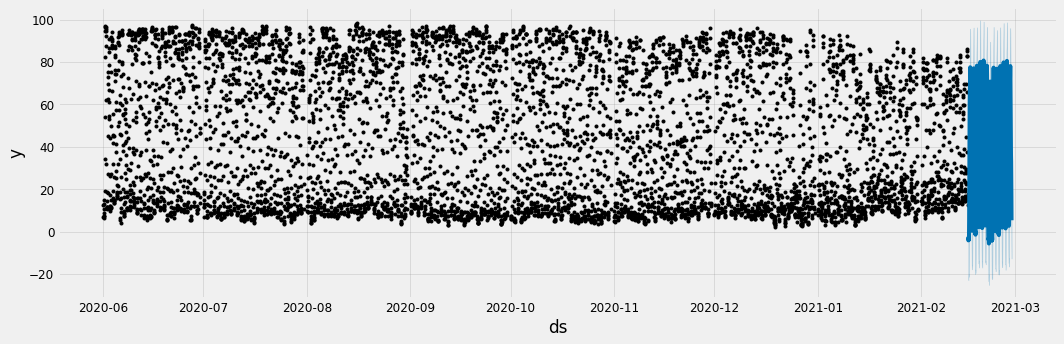

In [206]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst,ax=ax)
plt.show()

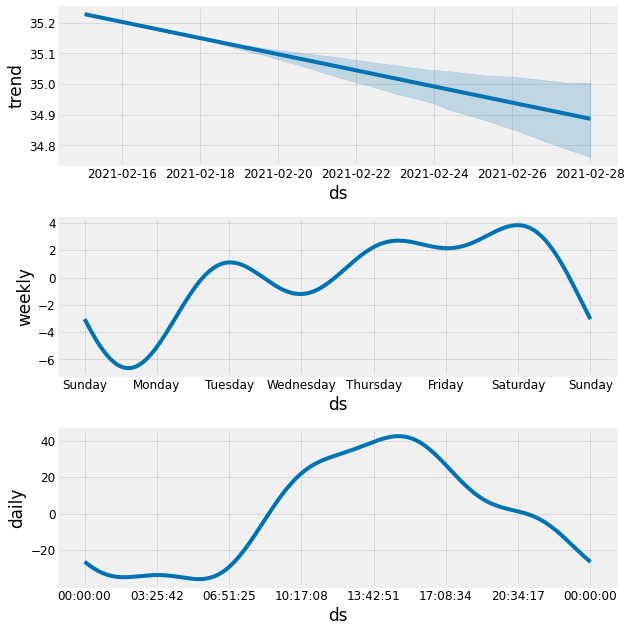

In [207]:
# Plot the components of the model
fig = model.plot_components(pjme_test_fcst)

Text(0.5, 1.0, 'Forecast (blue) vs. actual (red)')

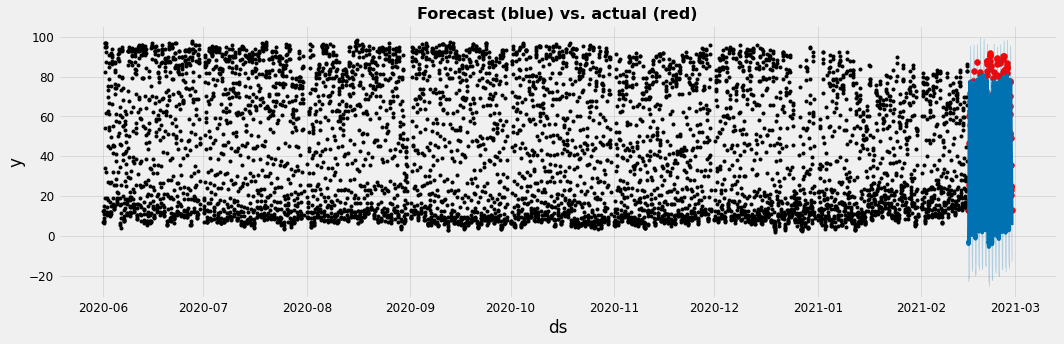

In [208]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.title('Forecast (blue) vs. actual (red)', fontsize = 16, weight = 'bold');
ax.scatter(pjme_test['date'], pjme_test['occupancy_rate'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

<ipython-input-219-b8b9374dc3d6>:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ax.set_xbound(lower=pd.datetime(2021,2,16),
<ipython-input-219-b8b9374dc3d6>:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  upper=pd.datetime(2021,3,1))


(-30.0, 100.0)

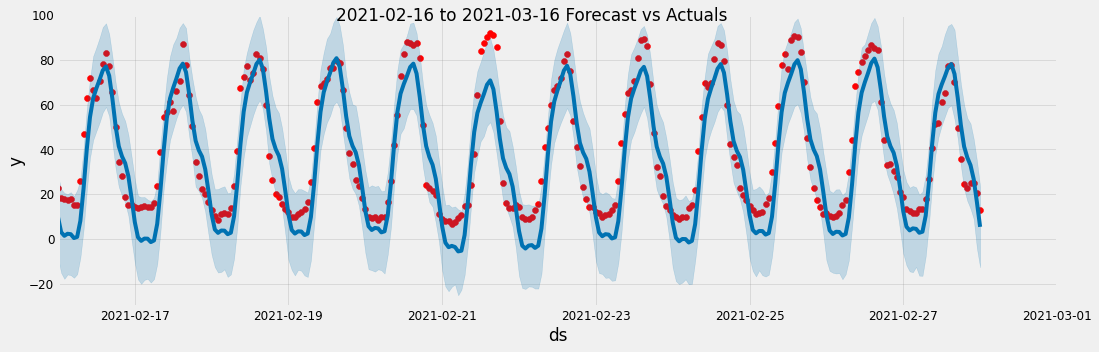

In [219]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test['date'], pjme_test['occupancy_rate'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower=pd.datetime(2021,2,16),
              upper=pd.datetime(2021,3,1))
ax.set_ylim(-30, 100)
plot = plt.suptitle('2021-02-16 to 2021-03-16 Forecast vs Actuals')

In [215]:
mean_squared_error(y_true=pjme_test['occupancy_rate'], y_pred=pjme_test_fcst['yhat'])

1501.4718017219782

**Model performance evaluation**

In [216]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['occupancy_rate'], y_pred=pjme_test_fcst['yhat'])

130.44262300894303

In [217]:
mean_absolute_error(y_true=pjme_test['occupancy_rate'],y_pred=pjme_test_fcst['yhat'])

31.159752289545903